In [40]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
from skimage import io
from skimage import color
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def folder_images(path):
    images = []
    for filename in tqdm(os.listdir(path)):
        img = cv2.imread(os.path.join(path,filename))
        if img is not None:
            images.append(img)
    return images

In [4]:
path= '/content/drive/MyDrive/MINI_MIAS/malignant_cases'
original_images = folder_images(path)
print('number of images : ',len(original_images))
print('resolution of images : ',original_images[0].shape)

100%|██████████| 51/51 [00:20<00:00,  2.51it/s]

number of images :  51
resolution of images :  (1024, 1024, 3)


100%|██████████| 51/51 [00:00<00:00, 320.80it/s]


51 (1024, 1024)


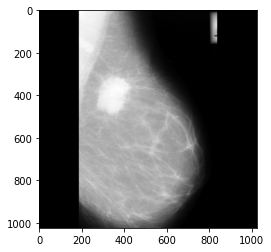

In [5]:
def original_gray(original):  #function to convert images from bgr to grayscale
    gray_img = cv2.cvtColor(original,cv2.COLOR_BGR2GRAY)
    return gray_img
gray_images = [] #oringinal/base mammogram images 
for img in tqdm(original_images): 
    gray_images.append(original_gray(img))    

print(len(gray_images),gray_images[0].shape)
plt.imshow(gray_images[0], cmap='gray')

100%|██████████| 51/51 [00:00<00:00, 559.10it/s]


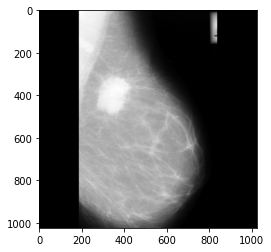

In [6]:
def right_orient_mammogram(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    
    if(left_nonzero < right_nonzero):
        image = cv2.flip(image, 1)

    return image
right_images = []
for img in tqdm(gray_images):
     right_images.append(right_orient_mammogram(img)) 

plt.imshow(right_images[0],cmap='gray')     

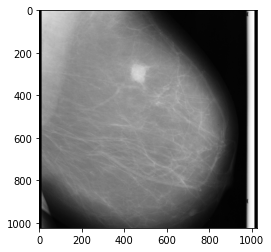

In [20]:
plt.imshow(right_images[5],cmap='gray')

100%|██████████| 51/51 [00:00<00:00, 221897.83it/s]


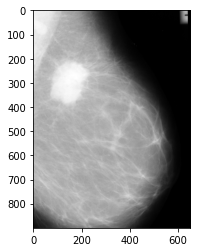

In [13]:
def crop(image):
  crop = image[100:1000,200:850]
  return crop

cropped_images = []

for img in tqdm(right_images):   
  cropped_images.append(crop(img))
plt.imshow(cropped_images[0],cmap='gray')  

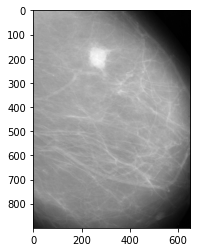

In [18]:
plt.imshow(cropped_images[5],cmap='gray')

100%|██████████| 51/51 [00:00<00:00, 2159.46it/s]


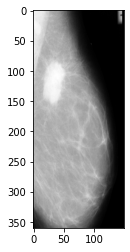

In [23]:
def resize(image):
  resized = cv2.resize(image, (150, 360))
  return resized
resized_images = []
for img in tqdm(cropped_images):
  resized_images.append(resize(img))

plt.imshow(resized_images[0],cmap='gray')  
  

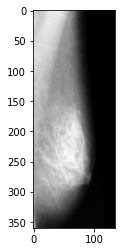

In [59]:
img3 = resized_images[2]
img31 = img3[0:1000,15:150]
plt.imshow(img31,cmap='gray')

In [68]:
def read_image(filename):
    #image = io.imread(filename)
    image = filename
    #image = color.rgb2gray(image)
    #image = right_orient_mammogram(image)
    #image = cv2.medianBlur(image,3)
    #clahe = cv2.createCLAHE(clipLimit = 5)
    #image = clahe.apply(image) + 0
    return image

In [27]:
from skimage.feature import canny
from skimage.filters import sobel

def apply_canny(image):
    canny_img = canny(image, 6)
    #cannny_img = cv2.Canny(image,20,75)
    return sobel(canny_img)

In [45]:
from skimage.transform import hough_line, hough_line_peaks

def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = list()
    print('\nAll hough lines')
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(abs(angle)), abs(dist)))
        x1 = 0
        y1 = (abs(dist) - x1 * np.cos(abs(angle))) / np.sin(abs(angle))
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': abs(dist),
            'angle': np.degrees(abs(angle)),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })
    
    return lines

In [46]:
def shortlist_lines(lines):
    MIN_ANGLE = 10
    MAX_ANGLE = 70
    MIN_DIST  = 5
    MAX_DIST  = 200
    
    shortlisted_lines = [x for x in lines if 
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]
    print('\nShorlisted lines')
    for i in shortlisted_lines:
        print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))
        
    return shortlisted_lines

In [47]:
from skimage.draw import polygon

def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])
    
    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)
    
    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

In [48]:
def display_image(filename):
    image = read_image(filename)
    canny_image = apply_canny(image)
    lines = get_hough_lines(canny_image)
    shortlisted_lines = shortlist_lines(lines)
    
    fig, axes = plt.subplots(1, 4, figsize=(15,10))
    fig.tight_layout(pad=3.0)
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0])
    
    
    axes[0].set_title('Right-oriented mammogram')
    axes[0].imshow(image, cmap=pylab.cm.gray)
    axes[0].axis('on') 
    
    axes[1].set_title('Hough Lines on Canny Edge Image')
    axes[1].imshow(canny_image, cmap=pylab.cm.gray)
    axes[1].axis('on')
    axes[1].set_xlim(0,image.shape[1])
    axes[1].set_ylim(image.shape[0])
    for line in lines:
        axes[1].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    axes[2].set_title('Shortlisted Lines')
    axes[2].imshow(canny_image, cmap=pylab.cm.gray)
    axes[2].axis('on')
    axes[2].set_xlim(0,image.shape[1])
    axes[2].set_ylim(image.shape[0])
    for line in shortlisted_lines:
        axes[2].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    rr, cc = remove_pectoral(shortlisted_lines)
    image[rr, cc] = 0
    axes[3].set_title('Pectoral muscle removed')
    axes[3].imshow(image, cmap=pylab.cm.gray)
    axes[3].axis('on') 
    
    plt.show()  

In [60]:
cv2.imwrite('/content/drive/MyDrive/MINI_MIAS/resized2.jpg',img31)

True

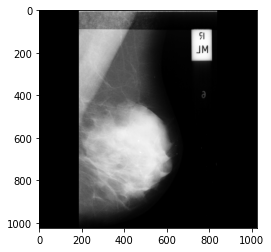

In [63]:
image_mias = cv2.imread('/content/drive/MyDrive/dump/mdb002.png')
gray_mias = cv2.cvtColor(image_mias,cv2.COLOR_BGR2GRAY)
plt.imshow(gray_mias,cmap='gray')

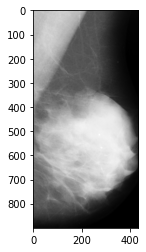

In [67]:
gray_mias1 = gray_mias[100:1000,195:630]
plt.imshow(gray_mias1,cmap='gray')

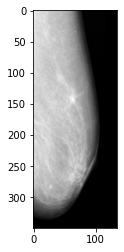

In [83]:
 #resized_images[11]
image11 = resized_images[11][0:350,15:150]
plt.imshow(image11,cmap='gray') 


All hough lines
Angle: 23.63, Dist: 35.55
Angle: 12.57, Dist: 65.58
Angle: 21.62, Dist: 200.76
Angle: 18.60, Dist: 188.74
Angle: 26.65, Dist: 219.78

Shorlisted lines
Angle: 23.63, Dist: 35.55
Angle: 12.57, Dist: 65.58
Angle: 18.60, Dist: 188.74


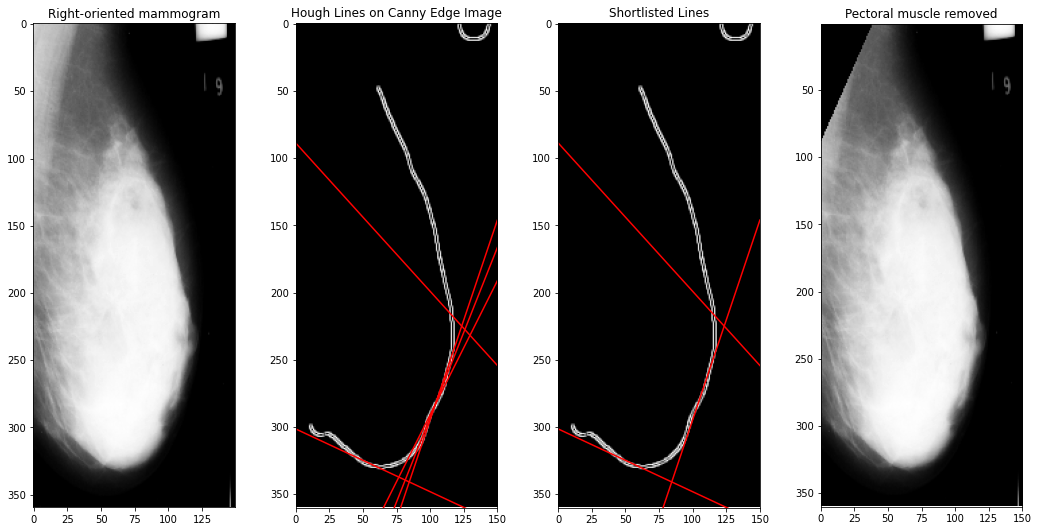

In [ ]:
 display_image(image11)